In [84]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime

%matplotlib inline
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

Current working directory: /home/koz/koz/NYCDSA/bootcamp-resources/ML/Lab/E-Retailers


In [109]:
orders_file = pd.read_csv("./data/Orders.csv")
returns_file = pd.read_csv("./data/Returns.csv")
orders = pd.DataFrame(orders_file)
returns = pd.DataFrame(returns_file)



In [55]:
orders.describe()
orders.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority'],
      dtype='object')

In [110]:
convert_to_numeric_dollars = lambda s: int(s.replace("$","").replace(".","").replace(",",""))/100

orders.Profit = orders.Profit.map(convert_to_numeric_dollars)
orders.Sales = orders.Sales.map(convert_to_numeric_dollars)


In [57]:
returns.describe()
returns.columns

Index(['Returned', 'Order ID', 'Region'], dtype='object')

In [115]:

orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders['Ship.Date'] = pd.to_datetime(orders['Ship.Date'])
orders['Order.Month'] = orders['Order.Date'].apply(lambda x: x.month_name())
orders['Order.Month.Num'] = orders['Order.Date'].apply(lambda x: x.month)
orders['Order.Year'] = orders['Order.Date'].apply(lambda x: x.year)
orders['Order.Date_year_month'] = orders['Order.Date'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
orders['Order.Date_year_month'] = pd.to_datetime(orders['Order.Date_year_month'], infer_datetime_format=True)

In [117]:
import plotly.io as pio
pio.renderers.default = 'iframe'
QuantityByMonth = orders.groupby(['Order.Date_year_month']).agg(Monthly_Quantity=('Quantity', 'sum')).reset_index()
fig = px.line(QuantityByMonth.sort_values(by=['Order.Date_year_month'], ascending=[True]), x='Order.Date_year_month', y='Monthly_Quantity')
fig

<AxesSubplot:xlabel='Order.Month.Num'>

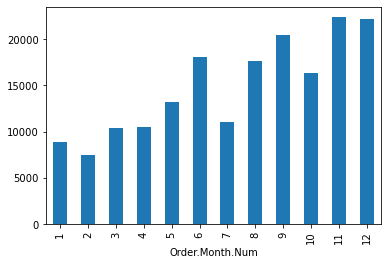

In [118]:
orders_by_month = orders.groupby('Order.Month.Num')
_ = orders_by_month['Quantity'].agg(sum)
_.plot.bar()

<AxesSubplot:xlabel='Order.Month.Num'>

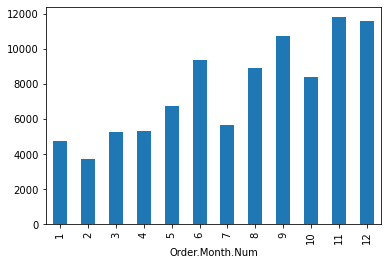

In [119]:
consumer_orders = orders[orders.Segment == "Consumer"]
consumer_orders_by_month = consumer_orders.groupby('Order.Month.Num')
_ = consumer_orders_by_month['Quantity'].agg(sum)
_.plot.bar()

<AxesSubplot:xlabel='Order.Month.Num'>

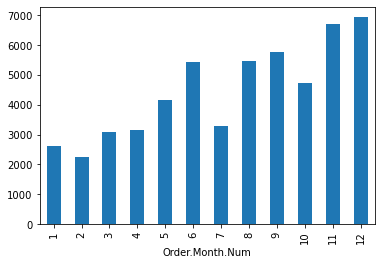

In [120]:
corporate_orders = orders[orders.Segment == "Corporate"]
corporate_orders_by_month = corporate_orders.groupby('Order.Month.Num')
_ = corporate_orders_by_month['Quantity'].agg(sum)
_.plot.bar()

In [45]:
#From here it seems pretty clear that this dataset has seasonality.

#In particular, the first 5 months of the year are significantly slower than the rest,
#and this holds for corporate and consumer orders both

In [46]:
returns[:10]

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania
5,Yes,ID-2013-AB1001527-41439,Eastern Asia
6,Yes,ES-2015-RA1994545-42218,Western Europe
7,Yes,CA-2014-TB21280140-41724,Central US
8,Yes,ES-2014-JF15295120-41924,Southern Europe
9,Yes,IN-2014-NM1844527-41800,Eastern Asia


In [89]:
returns.columns = ['Returned', 'Order.ID', 'Region']
merge_returns = pd.merge(orders,returns, how='left', on=['Order.ID','Region'])
merge_returns.shape

(51290, 28)

In [90]:
merge_returns_only = merge_returns[merge_returns.Returned == 'Yes']
merge_returns_only.shape

(2202, 28)

<AxesSubplot:xlabel='Order.Year,Returned'>

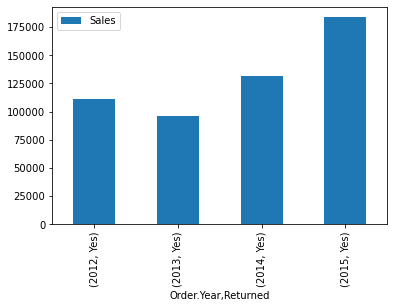

In [91]:
_ = merge_returns_only.groupby(['Order.Year','Returned']).agg({'Sales': 'sum'})
_.plot.bar()

In [92]:
merge_returns["Returned"] = merge_returns["Returned"].fillna(value="No")

In [94]:
y = merge_returns["Returned"]
merge_returns['ProcessTime'] = (merge_returns['Ship.Date'] - merge_returns['Order.Date']).dt.days

In [96]:
num_prod_returns = merge_returns.groupby('Product.ID')[['Returned']].agg('sum')
num_prod_returns
#broken


,Returned
Product.ID,
FUR-BO-3174,NoNo
FUR-BO-3175,NoNoNoNoNoNoNoNo
FUR-BO-3176,NoNoNoNoNoYes
FUR-BO-3177,NoNoNoNoNoNoNoNo
FUR-BO-3409,NoNoNoNoNoNoNoNo
...,...
TEC-PH-6365,YesNoNoNoNoNoNoNoNoNo
TEC-PH-6413,NoNoNoNoNoYes
TEC-PH-6425,YesNoNoNoNoNoNo
